Test VAE model

In [1]:
# prepare data
from data_utils import get_data
dataset_used = 'MNIST'
train_data_loader, val_data_loader, _, __ = get_data(dataset_used, 1)

Train size:  54000


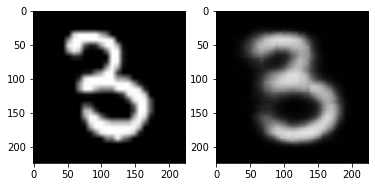

In [2]:
from vae import VAE
import matplotlib.pyplot as plt
import torch 

model = VAE(latent_dim=512).eval()
model_name = 'vae_mark'+str(model.mark)+'_'+dataset_used+'.pth'
model.load_state_dict(torch.load('models/'+model_name))
model.eval()
fig, axs = plt.subplots(1, 2)
# sample = model.sample(num_samples = 1,
#                       current_device = device)[0].permute(1, 2, 0)
# axs[0].imshow(sample.cpu().detach().numpy())
for batch in val_data_loader:
    if dataset_used == 'MNIST':
        img = batch[0]
    elif dataset_used == 'MPII':
        img = batch['image']
    img_show = img.squeeze(0).permute(1, 2, 0)
    axs[0].imshow(img_show.detach().numpy())
    gen = model(img)[0].squeeze(0).permute(1, 2, 0)
    axs[1].imshow(gen.cpu().detach().numpy())
    plt.show()
    break